## UM Canopy Height issues

Missing values in Canopy height have been observed over Macquarie and Campbell Islands in the Southern Ocean. This causes immediate failure of any UM task due to ingestion of NaNs into the wind computations.

Canopy heights are computed within a rose/cycl task in a reconfiguration suite, e.g. task **app/ancil_canopy_heights** in suite **u-dg767**

The python code used to compute canopy height is installed at **~/cylc-run/u-dg767/src/contrib/Apps/CanopyHeights/ancil_canopy_heights.py**

From the source code comments in **ancil_canopy_heights.py**
```
"""
Derive the canopy heights from the leaf area index by the following relation::
 
    Canopy height = height factor * LAI^(2/3)
 
Following this, override all tree PFTS using a trees dataset by the following
method:
- Regrid the tree source dataset to the target grid.
- Make this field consistent with the landsea mask of the LAI by performing an
  indexed based nearest neighbour search, constraining y to a distance of 50km
  (100km latitude band).
- Override tree fields we calculated from the above relation with those derived
  from this tree source.
The canopy heights returned represents the maximum value across the year
assigned to each month, due to the current basic handling of seasonal
variability.
"""
```
The python executable is called with the following command:
```
python_env \${CONTRIB_PATH}/Apps/CanopyHeights/ancil_canopy_heights.py ${lai} \
       --canopy-height-factors ${canopy_height_factors} --trees-dataset ${trees} \
       -o ${TMPDIR}/canopy_heights.nc --ants-config ${ANCIL_CONFIG} &&
       python_env ancil_2anc.py \
       ${lai} ${TMPDIR}/canopy_heights.nc -o ${output}
```
where
```
lai=/home/548/pag548/cylc-run/u-dg767/share/data/ancils/Gippsland/era5/lai.nc
canopy_height_factors=/g/data/access/TIDS/UM/ancil/data/transforms/canopy_height_factors_gl9.json
trees=/home/548/pag548/cylc-run/u-dg767/share/data/etc/ancil_master_ants/vegetation/
      canopy/simard/v1/Simard_Pinto_3DGlobalVeg_JGR.nc
```

The resulting output netCDF file is than added to the ancilary file `qrparm.veg.func`. Examination of the multi-level canopy data over the southern ocean shows it is missing data for level 1 and 2 over the two islands, but data is present for levels 3,4 and 5

In [41]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from pathlib import Path
import ants
import iris
import os
import warnings
import json

In [2]:
home_dir=os.environ['HOME']
HOME=Path(home_dir)
ROSE ='u-dg767'
REGION_DIR = Path(HOME / 'cylc-run' / ROSE / 'share/data/ancils/')
veg_cubes = ants.load ( REGION_DIR / 'Gippsland/era5/qrparm.veg.func')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/mule/stashmaster.py:284: UserWarning: Ancillary files do not define the UM version number in the Fixed Length Header. No STASHmaster file loaded: Fields will not have STASH entries attached.
  warnings.warn(msg)


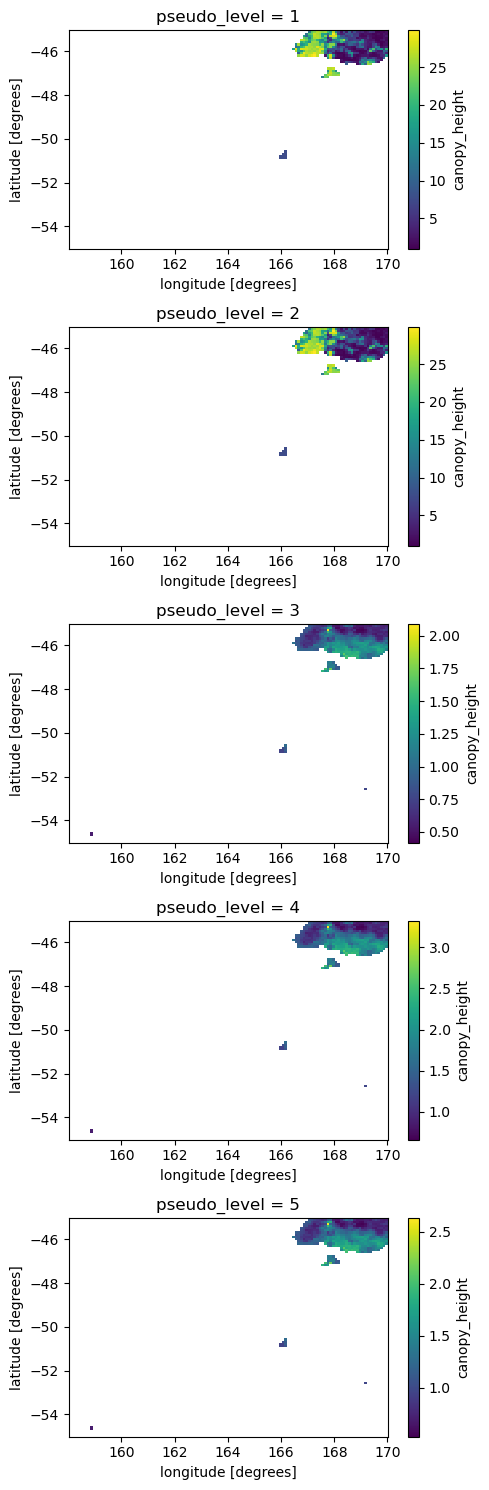

In [3]:
canopy_cube, = [ cube for cube in veg_cubes if cube.name() == 'canopy_height' ]
canopy_height = xr.DataArray.from_iris(canopy_cube)

fig,ax=plt.subplots(5,1,figsize=(5,15))

for level in canopy_height.dim_0:
    da = canopy_height.sel(dim_0=level,latitude=slice(-55,-45),longitude=slice(158,170)).\
         mean('time').plot(ax=ax.flatten()[level])
plt.tight_layout()

Note the presence of Macquarie Island (-54.6 S, 158.9 E) and Campbell Island (-52.5 S, 169.1 E) in the bottom three plots only.

As the algorithm correctly produces data for some levels, but not others, this suggests this probablem can be fixed at the source level, rather than as a post-production adjustment.

It's also likely this issue occurs at other islands, as other AUS2200 runs have generated similar errors in areas of Pacific Islands. Current AUS2000 runs are in progress to verify this.

Let's examine the inputs used to compute canopy height. First, leaf-area index.

In [33]:
warnings.filterwarnings('ignore',module='mule') 
warnings.filterwarnings('ignore',module='iris') 

master_lai = Path(HOME / 'cylc-run' / ROSE / 'share/data/etc/ancil_master_cap/vegetation/lai/modis_4km/v1/qrparm.data')
master_lai_cube, = ants.load(master_lai)
master_lai_cube

<iris 'Cube' of leaf_area_index / (1) (time: 12; latitude: 4320; longitude: 8640)>

This is a monthly climatology with some odd latitude co-ordinates. Let's plot the first month

In [5]:
tcoord = master_lai_cube.coord("time")
time_constr = iris.Constraint(time=lambda t: t.point == tcoord.units.num2date(tcoord.points[0]))
master_lai_da = xr.DataArray.from_iris(master_lai_cube.extract(time_constr))
master_lai_da

<xarray.DataArray 'leaf_area_index' (latitude: 4320, longitude: 8640)> Size: 299MB
dask.array<filled, shape=(4320, 8640), dtype=float64, chunksize=(1440, 8640), chunktype=numpy.ndarray>
Coordinates:
  * latitude      (latitude) float32 17kB 90.04 90.08 90.12 ... 269.9 270.0
  * longitude     (longitude) float64 69kB 0.04167 0.08334 0.125 ... 360.0 360.0
    pseudo_level  int64 8B ...
    time          datetime64[ns] 8B ...
Attributes:
    standard_name:    leaf_area_index
    source:           Data from Met Office Unified Model
    STASH:            m01s00i217
    grid_staggering:  3

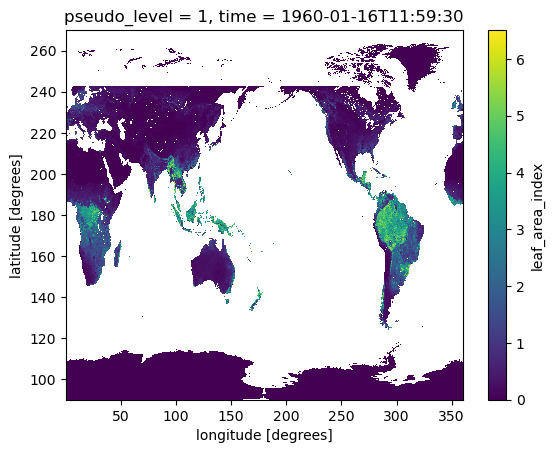

In [6]:
master_lai_da.plot()

The latitude co-ordinates for leaf-area-index are offset by 180 degrees. Is the northern hemipshere anomaly a product of the xarray conversion of the cube? Iris is unable to plot this file. What does the raw data look like?

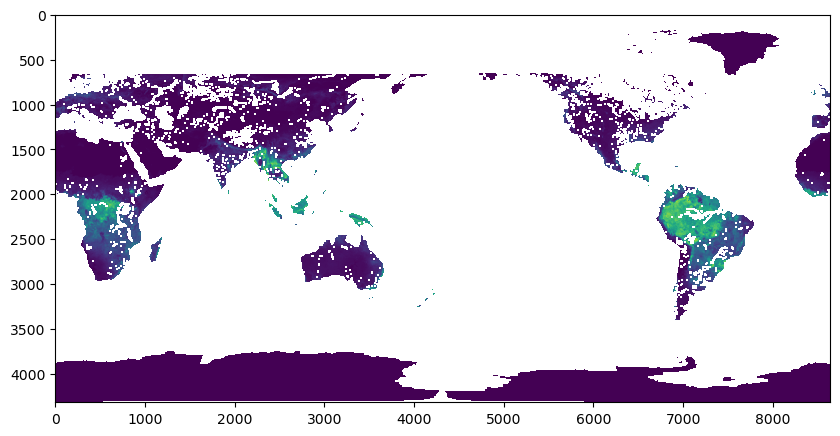

In [10]:
fig=plt.figure(figsize=(10,10))
plt.imshow(master_lai_cube.extract(time_constr).data[::-1])

That confirms there are issues with the underlying data which could cause issues with global models.

Let's examine the leaf-area index for our two islands for each month.

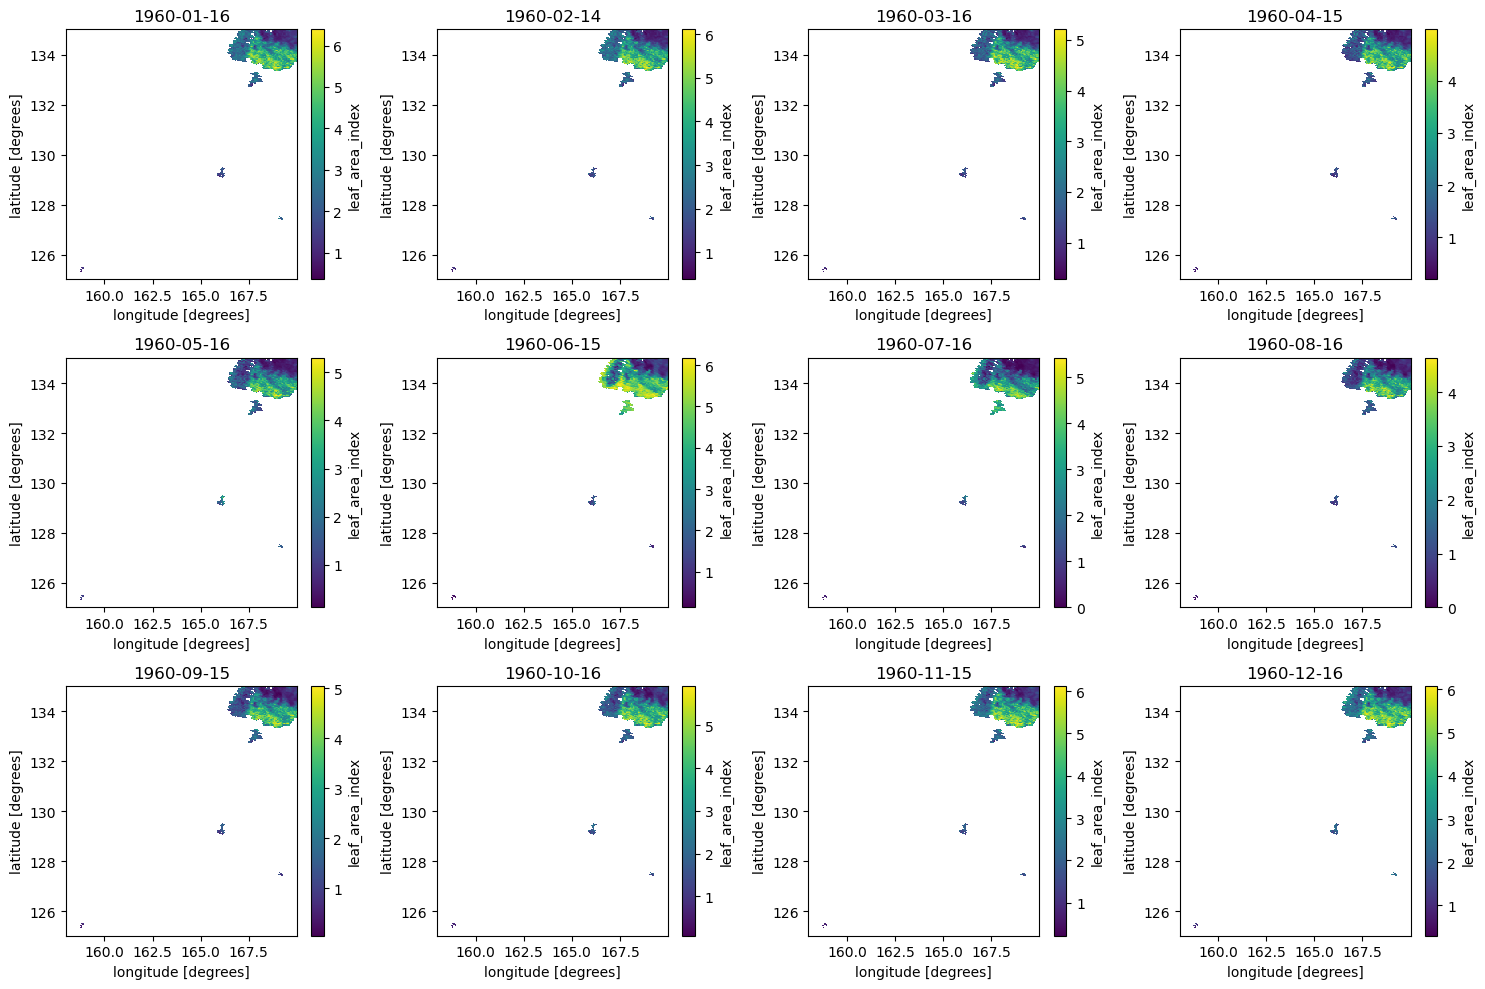

In [32]:
fig,ax=plt.subplots(3,4,figsize=(15,10))

for i in range(12):
    time_constr = iris.Constraint(time=lambda t: t.point == tcoord.units.num2date(tcoord.points[i]))
    master_lai_da = xr.DataArray.from_iris(master_lai_cube.extract(time_constr))
    master_lai_da.sel(latitude=slice(-55+180,-45+180),longitude=slice(158,170))\
                 .plot(ax=ax.flatten()[i])
    ax.flatten()[i].set_title(f'{pd.to_datetime(master_lai_da.time.data).strftime("%Y-%m-%d")}')
plt.tight_layout()

Ok so the islands exist in the leaf-area index for every month.

Let's check the tree dataset.

In [34]:
master_tree_file = Path(HOME / 'cylc-run' / ROSE / 'share/data/etc/ancil_master_ants/vegetation/canopy/simard/v1/Simard_Pinto_3DGlobalVeg_JGR.nc')
master_tree = xr.open_dataset(master_tree_file)

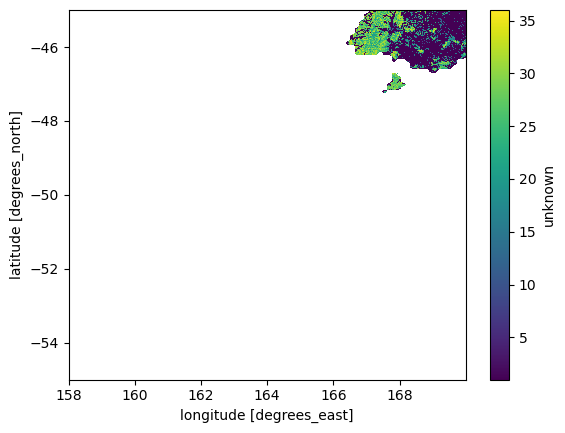

In [36]:
master_tree.unknown.sel(latitude=slice(-55,-45),longitude=slice(158,170)).plot()

This is consistent with the fact that Macquaire and Cambell island are tree-less!

In [40]:
canopy_height_file=Path('/g/data/access/TIDS/UM/ancil/data/transforms/canopy_height_factors_gl9.json')
f = open(canopy_height_file)
canopy_height_data = json.load(f)

In [39]:
canopy_height_data

{'canopy_height_factors': [6.5, 6.5, 0.5, 0.5, 1.0],
 'jules_classes': [1, 2, 3, 4, 5]}

So there are no obvious reasons why the code produces NaNs for pseudo-levels 1 and 2 for these islands, unless it's an issue because the islands are tree-less.